<a href="https://colab.research.google.com/github/erinmcmahon26/NLP-MovieReviews/blob/main/Knowledge_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries and ingest data

In [1]:
! python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=602f18cb845f6aa8470fa2d3205cba19af7d7a3df1f17276521caf5191ab592a
  Stored in directory: /tmp/pip-ephem-wheel-cache-hcbuotvq/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import spacy
from spacy.matcher import Matcher 

from tqdm import tqdm

In [3]:
# inital en_core_web_lg did not download so we had to try again
import spacy.cli

spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
nlp = spacy.load('en_core_web_lg')

en_core_web_lg is the largest English model of spaCy. 

https://spacy.io/models/en 

In [5]:
corpus=pd.read_csv(r'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_Sec57_2202_ClassCorpus_v2.csv')

In [6]:
corpus.head(10)

,Doc_ID,DSI_Title,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Text
0,1,EMU_Doc1_TheConjuring3,EMU,Horror,Negative,The Conjuring 3,I must admit that when I sat down to watch the...
1,2,EMU_Doc2_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,While The Conjuring franchise has stood as one...
2,3,EMU_Doc3_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,We’re well into the world and the lore of the ...
3,4,EMU_Doc4_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,James Wan's 2013 feature The Conjuring was som...
4,5,EMU_Doc5_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,Two Conjuring films and several spinoffs estab...
5,6,EMU_Doc6_TheConjuring3,EMU,Horror,Positive,The Conjuring 3,"Right from the first movie, James Wan had bigg..."
6,7,EMU_Doc7_TheConjuring3,EMU,Horror,Negative,The Conjuring 3,Money is no issue for The Conjuring films. The...
7,8,EMU_Doc8_TheConjuring3,EMU,Horror,Negative,The Conjuring 3,When a film trots out the phrase “based on a t...
8,9,EMU_Doc9_TheConjuring3,EMU,Horror,Negative,The Conjuring 3,"The so-called ""Conjuring universe"" is so succe..."
9,10,EMU_Doc10_TheConjuring3,EMU,Horror,Negative,The Conjuring 3,I remember seeing James Wan’s The Conjuring fo...


### Entities, Relations, and Knowledge graph for just the conjuring movie

In [7]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier + " "+ prefix + " " + tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [8]:
def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                   {'DEP':'prep','OP':"?"},
                   {'DEP':'agent','OP':"?"},  
                   {'POS':'ADJ','OP':"?"}] 
        
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except Exception as e:
        pass

In [11]:
corpus['Movie Title'].value_counts()

The Conjuring 3                                           10
Mission Impossible Fallout                                10
Encanto                                                   10
Guardians of the Galaxy                                   10
Frozen II                                                 10
Red Notice                                                10
The Ring                                                  10
Arrival                                                   10
Us                                                        10
Spider Man 3                                              10
Hereditary                                                10
The Grand Budapest Hotel                                  10
Pirates of the Caribbean: The Curse of the Black Pearl    10
The Matrix Resurrections                                  10
Cruella                                                   10
Speed Racer                                               10
Lamb                    

We will be exploring the entities and relationships in the movie "The Conjuring 3"

In [12]:
# get The Conjuring 3 movie reviews out (tc3)
tc3_reviews = corpus.loc[corpus['Movie Title'] == 'The Conjuring 3', 'Text'].reset_index(drop=True)

In [13]:
tc3_reviews[0]

'I must admit that when I sat down to watch the 2021 addition to "The Conjuring" franchise, I was not harboring much of any overly great expectations or hopes, because since the first movie it has been a steady downward slope. Still, as I had the chance to sit down and watch "The Conjuring: The Devil Made Me Do It" from writers David Leslie Johnson-McGoldrick and James Wan. So of course I did it. And I have to say that director Michael Chaves managed to deliver a movie that was only slightly entertaining. "The Conjuring: The Devil Made Me Do It" was a whole lot of nothing going on, and you can essentially just watch the beginning and the last 25 minutes of the movie and skip on everything in between. The storyline written for "The Conjuring: The Devil Made Me Do It" was bland and slow paced, with very little of much excitement or interest happening in between the start and the end of the movie. And that ultimately led to a less than mediocre movie experience for me. And yeah, I am a ho

In [14]:
# want to explore entities and relations for all Conjuring reviews
all_tc3_reviews = ' '.join(tc3_reviews)
all_tc3_reviews[0]

'I'

In [15]:
# running all conjuring reviews through the "en_core_web_lg" spaCy model
tc3_docs = nlp(all_tc3_reviews)

In [16]:
# create sentences from reviews
# var.sents is from spaCy and is used to iterate over sentences in my tc3_docs variable
tc3_sentences = [str(x) for x in list(tc3_docs.sents)]

In [17]:
len(tc3_sentences)

414

Using example_sent, we are looking at the tokens and their syntactic dependencies (.dep_). In short, this shows us the relation between the tokens.

In [18]:
example_sent = tc3_sentences[0]

In [19]:
example_nlp = nlp(example_sent)

In [20]:
for tok in example_nlp:
    print(tok.dep_)

nsubj
aux
ROOT
mark
advmod
nsubj
advcl
prt
aux
advcl
det
nummod
dobj
prep
punct
det
nmod
punct
pobj
punct
nsubj
aux
neg
ccomp
dobj
prep
det
advmod
amod
pobj
cc
conj
punct
mark
prep
det
amod
pobj
nsubj
aux
advcl
det
amod
amod
attr
punct


In [21]:
# assess entities in the example sentence
get_entities(example_sent)

['first  it', 'first  movie']

In [22]:
# assess relation between entities
get_relation(example_sent)

'admit'

In [23]:
# compare entities and relation to the full sentence
example_sent

'I must admit that when I sat down to watch the 2021 addition to "The Conjuring" franchise, I was not harboring much of any overly great expectations or hopes, because since the first movie it has been a steady downward slope.'

In [24]:
# get entity pairs for all conjuring sentences
entity_pairs = []

for i in tqdm(tc3_sentences):
  entity_pairs.append(get_entities(i))

100%|██████████| 414/414 [00:05<00:00, 81.92it/s]


In [25]:
entity_pairs[0]

['first  it', 'first  movie']

In [26]:
relations = [get_relation(i) for i in tqdm(tc3_sentences)]

100%|██████████| 414/414 [00:05<00:00, 82.02it/s]


In [27]:
relations[0]

'admit'

In [28]:
# extract subject (the first value in the entity pair)
source = [i[0] for i in entity_pairs]

In [29]:
# extract object (the second value in the entity pair)
target = [i[1] for i in entity_pairs]

In [30]:
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [31]:
kg_df.head()

,source,target,edge
0,first it,first movie,admit
1,I,Conjuring,Still
2,Me,Leslie Johnson McGoldrick,Made
3,So I,it,did
4,that,movie,have


In [32]:
# make everything lower case
for col in kg_df:
  kg_df[col] = kg_df[col].str.lower()

In [33]:
kg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  414 non-null    object
 1   target  414 non-null    object
 2   edge    414 non-null    object
dtypes: object(3)
memory usage: 9.8+ KB


In [34]:
# filter out empty values
for col in kg_df:
  kg_df = kg_df[kg_df[col] != '']

In [35]:
kg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 413
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  324 non-null    object
 1   target  324 non-null    object
 2   edge    324 non-null    object
dtypes: object(3)
memory usage: 10.1+ KB


In [36]:
kgraph = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

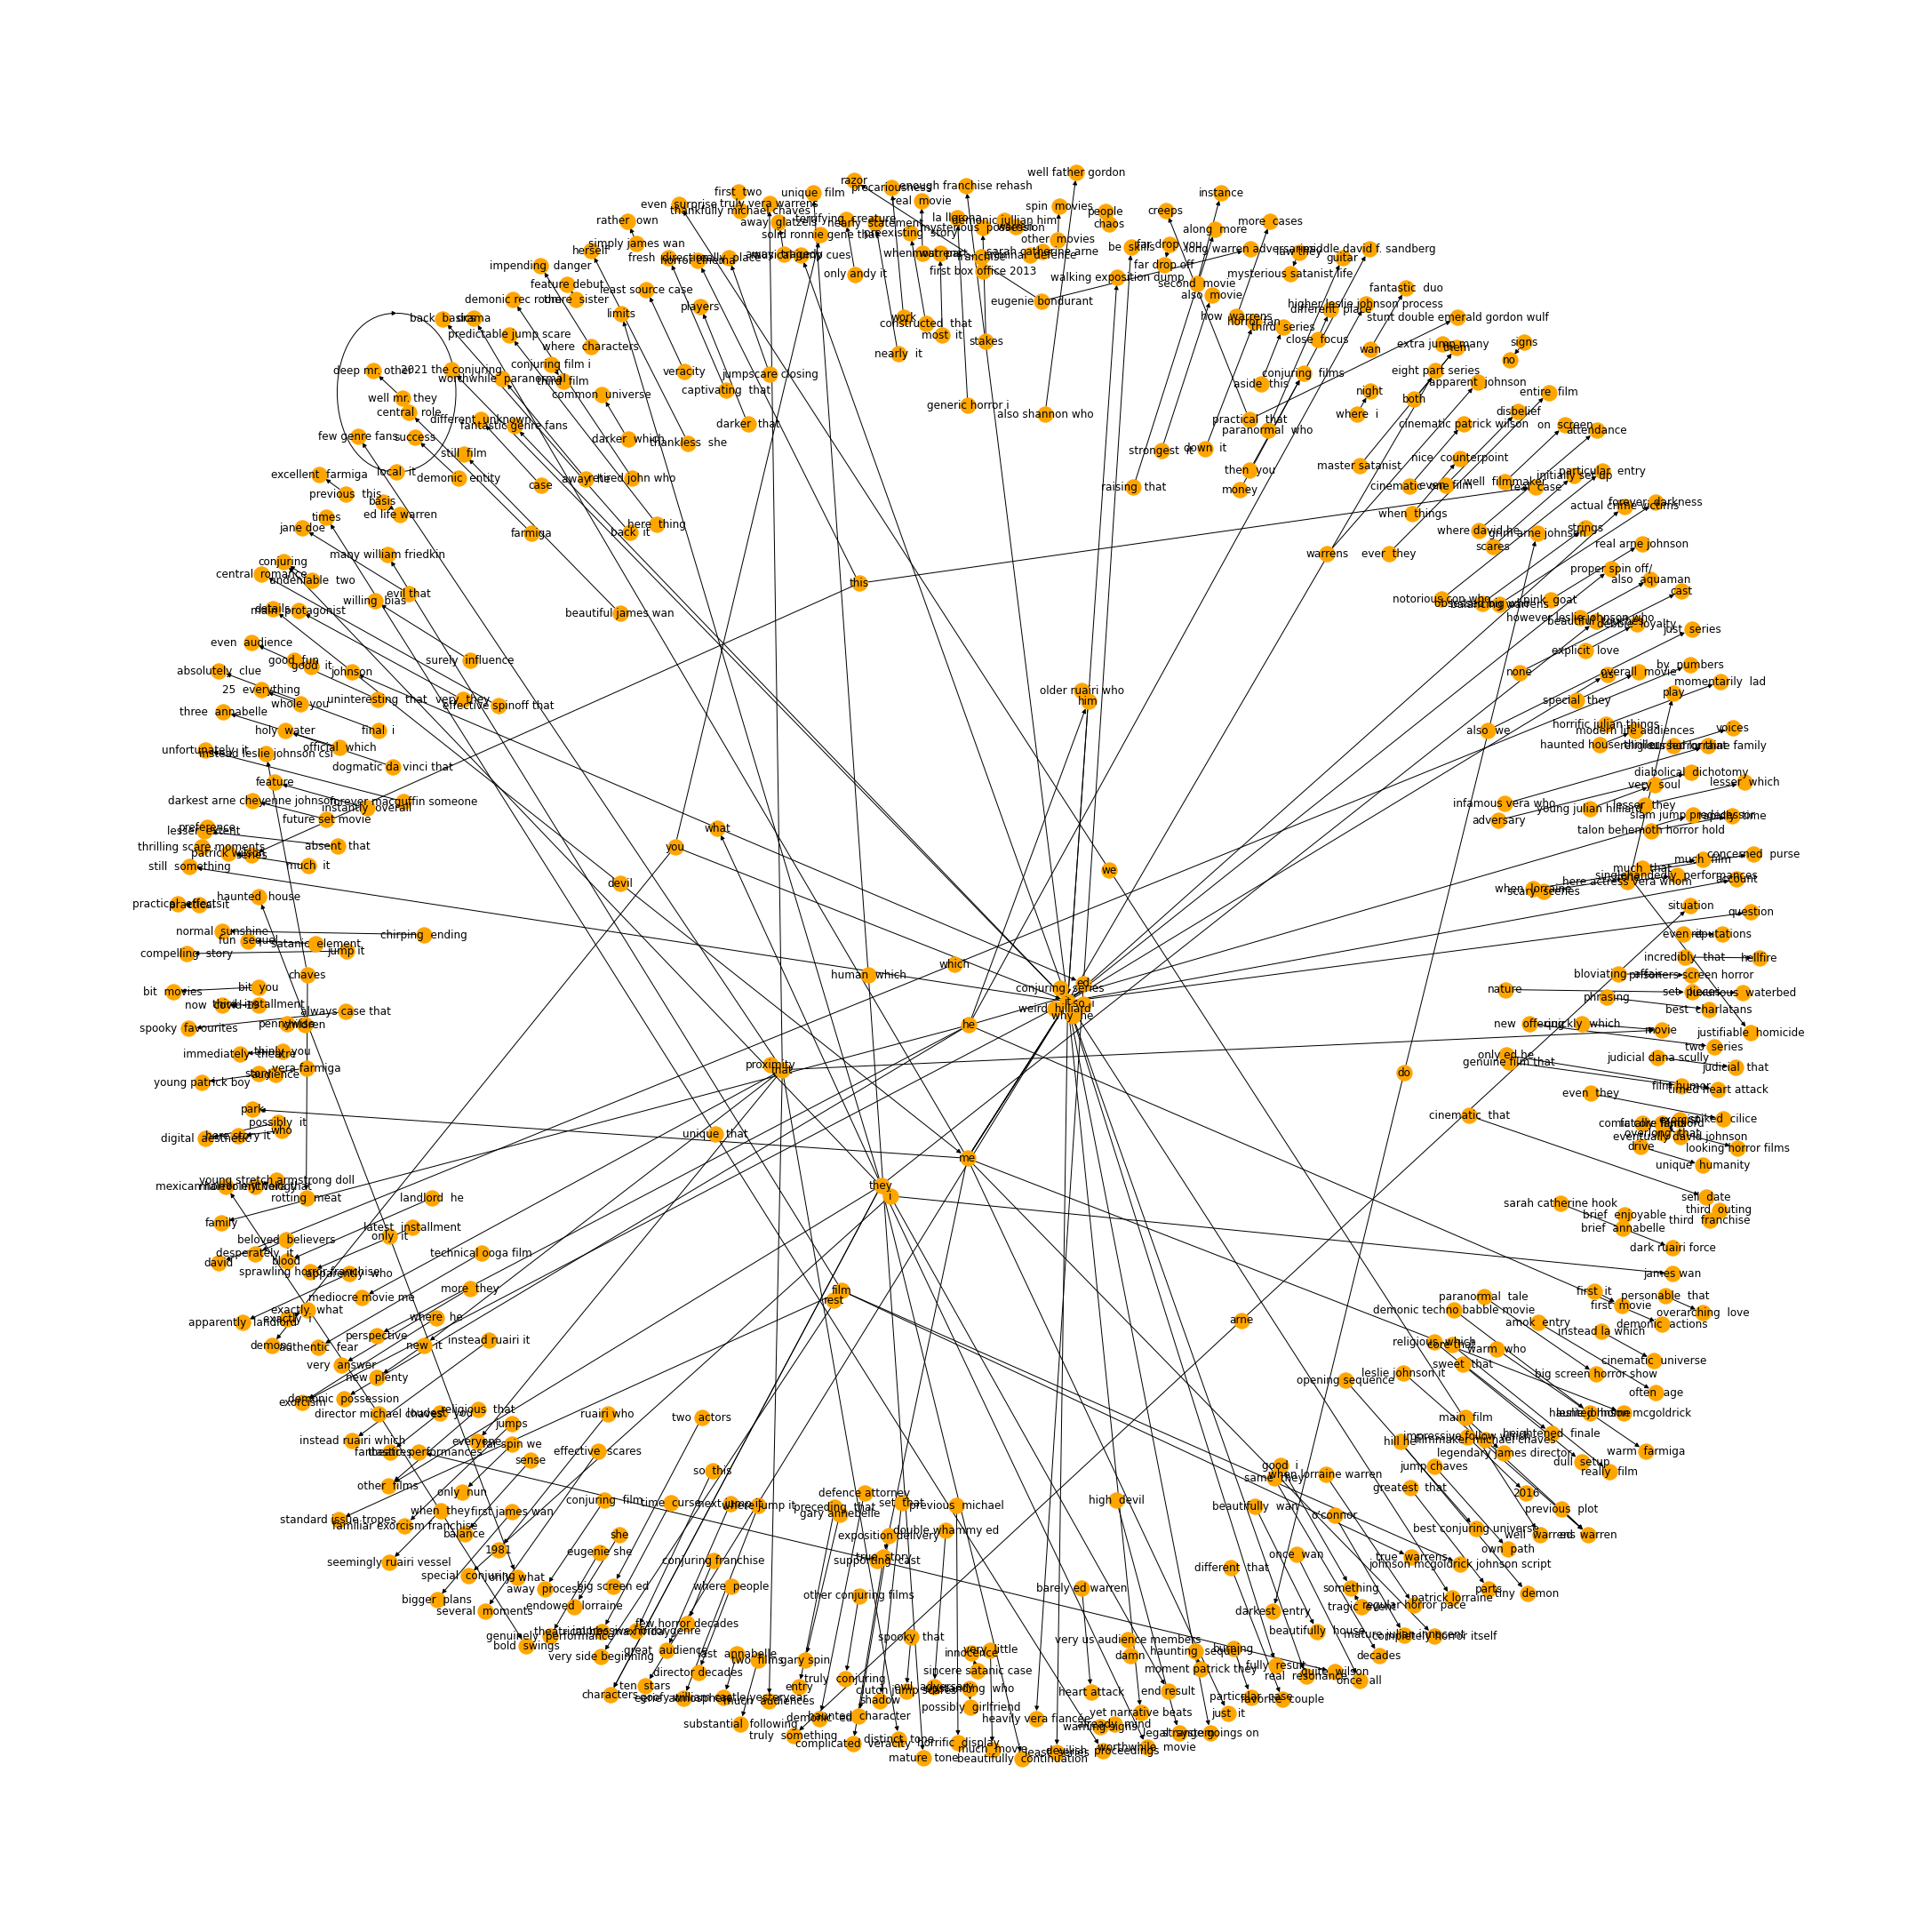

In [37]:
plt.figure(figsize=(30,30))
pos = nx.spring_layout(kgraph)
nx.draw(kgraph, with_labels=True,
        node_color='orange',
        edge_cmap=plt.cm.Blues,
        pos=pos)
plt.show()

In [57]:
# zoom in on the middle entities like he or ed or series 
entity_filter = (kg_df['source'] == 'film') | (kg_df['target'] == 'film')

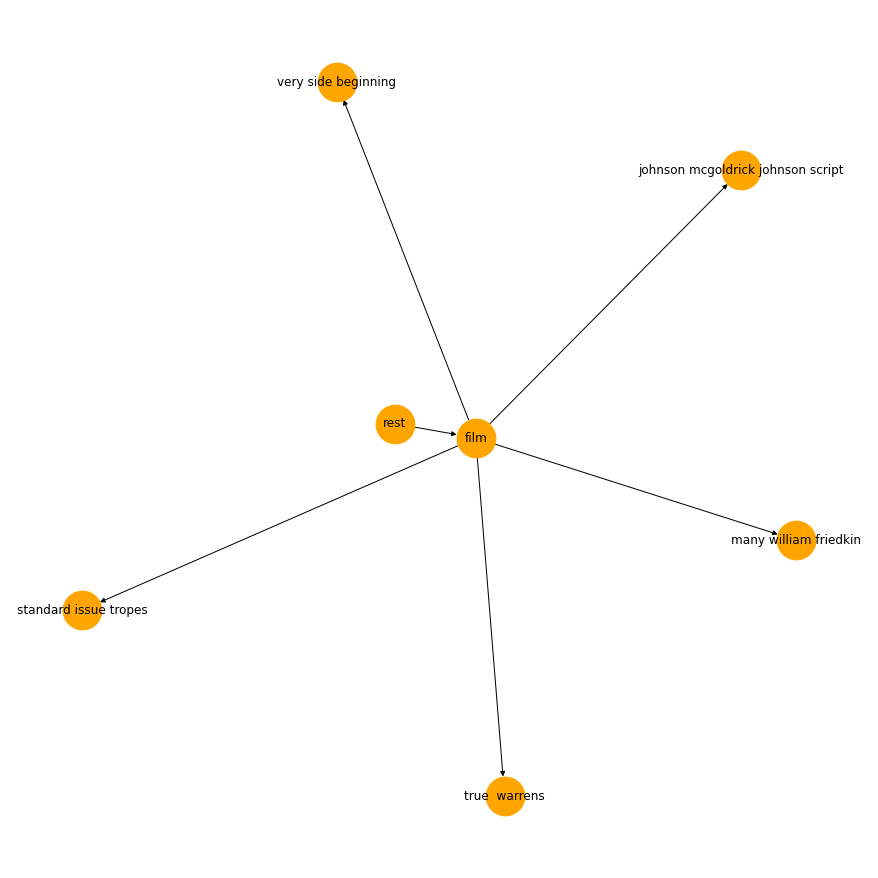

In [58]:
zoom_kgraph = nx.from_pandas_edgelist(kg_df[entity_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(zoom_kgraph, k=0.5) # k regulates the distance between nodes

nx.draw(zoom_kgraph, with_labels=True, 
        node_color='orange', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

### Entities, Relations, and Knowledge graph for all movie reviews

In [109]:
movie_reviews = corpus['Text'].reset_index(drop=True)

In [110]:
movie_reviews[0]

'I must admit that when I sat down to watch the 2021 addition to "The Conjuring" franchise, I was not harboring much of any overly great expectations or hopes, because since the first movie it has been a steady downward slope. Still, as I had the chance to sit down and watch "The Conjuring: The Devil Made Me Do It" from writers David Leslie Johnson-McGoldrick and James Wan. So of course I did it. And I have to say that director Michael Chaves managed to deliver a movie that was only slightly entertaining. "The Conjuring: The Devil Made Me Do It" was a whole lot of nothing going on, and you can essentially just watch the beginning and the last 25 minutes of the movie and skip on everything in between. The storyline written for "The Conjuring: The Devil Made Me Do It" was bland and slow paced, with very little of much excitement or interest happening in between the start and the end of the movie. And that ultimately led to a less than mediocre movie experience for me. And yeah, I am a ho

In [111]:
all_reviews = ' '.join(movie_reviews)

In [112]:
all_docs = nlp(all_reviews)

In [113]:
all_sents = [str(x) for x in all_docs.sents]

In [114]:
all_entity_pairs = []

for i in tqdm(all_sents):
  all_entity_pairs.append(get_entities(i))

100%|██████████| 8258/8258 [01:35<00:00, 86.15it/s]


In [115]:
all_relations = [get_relation(i) for i in tqdm(all_sents)]

100%|██████████| 8258/8258 [01:40<00:00, 82.29it/s]


In [116]:
all_source = [i[0] for i in all_entity_pairs]

In [117]:
all_target = [i[1] for i in all_entity_pairs]

In [118]:
full_kg_df = pd.DataFrame({'source': all_source, 'target': all_target, 'edge': all_relations})

In [119]:
for col in full_kg_df:
  full_kg_df[col] = full_kg_df[col].str.lower()

In [120]:
for col in full_kg_df:
  full_kg_df = full_kg_df[full_kg_df[col] != '']

In [121]:
from typing import List, Callable, Dict, Tuple, Set

In [122]:
def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='orange', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)

In [124]:
#plot_graph(full_kg_df, figsize=(27, 27), use_circular=True)